In [1]:
# -*- coding:utf8 -*-
import re
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from mydatools.plot import plot_grid_search_result

% matplotlib inline

## 获取数据

In [2]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
full_df = pd.concat([train_df, test_df], keys=['train', 'test'])
del(train_df)
del(test_df)
full_df.head()

0_13_all  0_13_female  0_13_male  0_17_all  0_17_female  0_17_male  \
train 0     18654         8945       9709     23603        11317      12286   
      1     13729         6800       6929     17700         8702       8998   
      2     11252         5336       5916     14884         7063       7821   
      3     24934        12152      12782     32063        15550      16513   
      4     11631         5408       6223     15237         7124       8113   

         0_6_all  0_6_female  0_6_male  16_29_all         ...          \
train 0     9576        4677      4899      17508         ...           
      1     6880        3414      3466      15164         ...           
      2     5879        2784      3095      19401         ...           
      3    13087        6442      6645       3292         ...           
      4     5706        2724      2982       5164         ...           

         water_km  water_treatment_km  work_all  work_female  work_male  \
train 0  0.992631           23.683460     98207        45930      52277   
      1  0.698081            1.317476     70194        34572      35622   
      2  0.468265            4.912660     63388        31575      31813   
      3  1.200336           15.623710    120381        60341      60040   
      4  0.820294           10.683540     68043        33807      34236   

         workplaces_km  young_all  young_female  young_male  \
train 0       0.884350      21154         10147       11007   
      1       0.686252      15727          7802        7925   
      2       1.510089      13028          6193        6835   
      3       0.622272      28563         13883       14680   
      4       0.892668      13368          6209        7159   

         zd_vokzaly_avto_km  
train 0           14.231961  
      1            9.242586  
      2            9.540544  
      3           17.478380  
      4            1.595898  

[5 rows x 292 columns]

* 对price_doc进行log1p处理

由于有了这个操作，score就是RMSE（而不是RMSLE）

In [3]:
full_df['price_doc'] = np.log1p(full_df['price_doc'])

* macroeconomy

In [4]:
macro_df = pd.read_csv('./input/macro.csv')
macro_df.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [5]:
# feats = macro_df.columns[macro_df.dtypes != 'object'].tolist()[40:60]
# num_feat = len(feats)
# num_row = int(np.ceil(num_feat / 3))
# fig, ax = plt.subplots(num_row, 3, figsize=(15, 4*num_row))
# for i in range(num_feat):
#     feat = feats[i]
#     cur_ax = ax[i//3][i%3] if num_row > 1 else ax[i]
#     cur_ax.plot(pd.to_datetime(macro_df['timestamp']), macro_df[feat].fillna(0))
# #     cur_ax.plot(pd.to_datetime(macro_df['timestamp']), macro_df[feat].fillna(macro_df[feat].mean()))
#     cur_ax.plot(pd.to_datetime(macro_df['timestamp']), macro_df[feat].fillna(method='ffill').fillna(method='bfill'))
#     cur_ax.set_title(feat)

In [6]:
# 缺失值
numerical_columns = macro_df.columns[macro_df.dtypes != 'object']
macro_df[numerical_columns] = macro_df[numerical_columns].fillna(method='ffill').fillna(method='bfill')

In [7]:
full_df = full_df.join(macro_df.set_index('timestamp'), on='timestamp')

## 特征处理

* 简单处理

把数值型特征加进去

In [8]:
feature_list = []
def add_feature(feats):
    global feature_list
    if type(feats) != list:
        feats = [feats]
    feature_list += [f for f in feats if f not in feature_list]
def remove_feature(feats):
    global feature_list
    if type(feats) != list:
        feats = [feats]
    feature_list = [f for f in feature_list if f not in feats]

In [9]:
numeric_feat = full_df.dtypes[full_df.dtypes != 'object'].index.tolist()
add_feature(numeric_feat)

In [10]:
remove_feature(['id', 'price_doc'])

* 数据清洗

In [11]:
# build_year
full_df.loc[(full_df['build_year'] < 1000) | (full_df['build_year'] > 2100), 'build_year'] = np.nan

* 处理偏倚数据

In [12]:
# skew_value = full_df[feature_list].apply(lambda x: skew(x)) # compute skewness
# min_value = full_df[feature_list].min()
# skewed_feats = skew_value[(skew_value > 0.75) & (min_value >= 0)].index
# full_df[skewed_feats] = np.log1p(full_df[skewed_feats])

* 加入日期相关特征

In [13]:
dt_df = pd.to_datetime(full_df['timestamp'])
full_df['timestamp_year'] = dt_df.apply(lambda x: x.year)
full_df['timestamp_month'] = dt_df.apply(lambda x: x.month)
full_df['timestamp_day'] = dt_df.apply(lambda x: x.day)
full_df['timestamp_weekday'] = dt_df.apply(lambda x: x.weekday())
add_feature(['timestamp_year', 'timestamp_month', 'timestamp_day', 'timestamp_weekday'])

* 字符串类型特征处理

In [14]:
# yes/no
yes_no_features = ['big_market_raion', 'big_road1_1line', 'culture_objects_top_25',
        'detention_facility_raion', 'incineration_raion',
        'nuclear_reactor_raion', 'oil_chemistry_raion', 'radiation_raion',
        'railroad_1line', 'railroad_terminal_raion',
        'thermal_power_plant_raion', 'water_1line',
    ]
full_df[yes_no_features] = full_df[yes_no_features].apply(lambda x: x.map({'yes': 1, 'no': 0}))
add_feature(yes_no_features)

In [15]:
# ecology (excellent|good|satisfactory|poor|no data)
full_df['ecology'] = full_df['ecology'].map({'excellent': 4, 'good': 3, 'satisfactory': 2, 'poor': 1, 'no data': np.nan})
add_feature('ecology')

In [16]:
# dummy
# product_type (Investment|OwnerOccupier|nan)
dummy_features = [
    'product_type', 
    'sub_area',
]
dummy_df = pd.get_dummies(full_df[dummy_features])
full_df[dummy_df.columns] = dummy_df
add_feature(dummy_df.columns.tolist())

In [17]:
# to numeric
# child_on_acc_pre_school (#!|7,311|3,013|16,765|nan)
# modern_education_share (nan|90,92|93,08|95,4918)
# old_education_build_share (nan|23,14|25,47|8,2517)
tonum_feats = ['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']
# 先将,转化成. 然后再进行to_numeric
full_df[tonum_feats] = full_df[tonum_feats].apply(lambda x: x.str.replace(',', '.'))
full_df[tonum_feats] = full_df[tonum_feats].apply(lambda x: pd.to_numeric(x, errors='coerce'))
add_feature(tonum_feats)

* 一些占比相关的特征

In [18]:
# sq
full_df['derive_life_sq_ratio'] = full_df['life_sq'] / full_df['full_sq']
full_df['derive_kitch_sq_ratio'] = full_df['kitch_sq'] / full_df['full_sq']

# children_preschool
full_df['derive_children_preschool_ratio'] = full_df['children_preschool'] / full_df['raion_popul']
full_df['derive_preschool_quota_prepopul'] = full_df['preschool_quota'] / full_df['children_preschool']
full_df['derive_preschool_education_centers_raion_prepopul'] = full_df['preschool_education_centers_raion'] / full_df['children_preschool']

# children_school
full_df['derive_children_school_ratio'] = full_df['children_school'] / full_df['raion_popul']
full_df['derive_school_quota_prepopul'] = full_df['school_quota'] / full_df['children_school']
full_df['derive_school_education_centers_raion_prepopul'] = full_df['school_education_centers_raion'] / full_df['children_school']
full_df['derive_school_education_centers_top_20_raion_prepopul'] = full_df['school_education_centers_top_20_raion'] / full_df['children_school']

# raion_pre_popul
full_df['derive_hospital_beds_raion_prepopul'] = full_df['hospital_beds_raion'] / full_df['raion_popul']
full_df['derive_healthcare_centers_raion_prepopul'] = full_df['healthcare_centers_raion'] / full_df['raion_popul']
full_df['derive_university_top_20_raion_prepopul'] = full_df['university_top_20_raion'] / full_df['raion_popul']
full_df['derive_sport_objects_raion_prepopul'] = full_df['sport_objects_raion'] / full_df['raion_popul']
full_df['derive_additional_education_raion_prepopul'] = full_df['additional_education_raion'] / full_df['raion_popul']
full_df['derive_culture_objects_top_25_raion_prepopul'] = full_df['culture_objects_top_25_raion'] / full_df['raion_popul']
full_df['derive_shopping_centers_raion_prepopul'] = full_df['shopping_centers_raion'] / full_df['raion_popul']
full_df['derive_office_raion_prepopul'] = full_df['office_raion'] / full_df['raion_popul']

# total popul
full_df['derive_male_f_ratio'] = full_df['male_f'] / full_df['full_all']
full_df['derive_female_f_ratio'] = full_df['female_f'] / full_df['full_all']
full_df['derive_young_all_ratio'] = full_df['young_all'] / full_df['full_all']
full_df['derive_young_male_ratio'] = full_df['young_male'] / full_df['full_all']
full_df['derive_young_female_ratio'] = full_df['young_female'] / full_df['full_all']
full_df['derive_work_all_ratio'] = full_df['work_all'] / full_df['full_all']
full_df['derive_work_male_ratio'] = full_df['work_male'] / full_df['full_all']
full_df['derive_work_female_ratio'] = full_df['work_female'] / full_df['full_all']
full_df['derive_ekder_all_ratio'] = full_df['ekder_all'] / full_df['full_all']
full_df['derive_ekder_male_ratio'] = full_df['ekder_male'] / full_df['full_all']
full_df['derive_ekder_female_ratio'] = full_df['ekder_female'] / full_df['full_all']
full_df['derive_0_6_all_ratio'] = full_df['0_6_all'] / full_df['full_all']
full_df['derive_0_6_male_ratio'] = full_df['0_6_male'] / full_df['full_all']
full_df['derive_0_6_female_ratio'] = full_df['0_6_female'] / full_df['full_all']
full_df['derive_7_14_all_ratio'] = full_df['7_14_all'] / full_df['full_all']
full_df['derive_7_14_male_ratio'] = full_df['7_14_male'] / full_df['full_all']
full_df['derive_7_14_female_ratio'] = full_df['7_14_female'] / full_df['full_all']
full_df['derive_0_17_all_ratio'] = full_df['0_17_all'] / full_df['full_all']
full_df['derive_0_17_male_ratio'] = full_df['0_17_male'] / full_df['full_all']
full_df['derive_0_17_female_ratio'] = full_df['0_17_female'] / full_df['full_all']
full_df['derive_16_29_all_ratio'] = full_df['16_29_all'] / full_df['full_all']
full_df['derive_16_29_male_ratio'] = full_df['16_29_male'] / full_df['full_all']
full_df['derive_16_29_female_ratio'] = full_df['16_29_female'] / full_df['full_all']
full_df['derive_0_13_all_ratio'] = full_df['0_13_all'] / full_df['full_all']
full_df['derive_0_13_male_ratio'] = full_df['0_13_male'] / full_df['full_all']
full_df['derive_0_13_female_ratio'] = full_df['0_13_female'] / full_df['full_all']
full_df['derive_young_female_ratio_female'] = full_df['young_female'] / full_df['female_f']
full_df['derive_work_female_ratio_female'] = full_df['work_female'] / full_df['female_f']
full_df['derive_ekder_female_ratio_female'] = full_df['ekder_female'] / full_df['female_f']
full_df['derive_0_6_female_ratio_female'] = full_df['0_6_female'] / full_df['female_f']
full_df['derive_7_14_female_ratio_female'] = full_df['7_14_female'] / full_df['female_f']
full_df['derive_0_17_female_ratio_female'] = full_df['0_17_female'] / full_df['female_f']
full_df['derive_16_29_female_ratio_female'] = full_df['16_29_female'] / full_df['female_f']
full_df['derive_0_13_female_ratio_female'] = full_df['0_13_female'] / full_df['female_f']
full_df['derive_young_male_ratio_male'] = full_df['young_male'] / full_df['male_f']
full_df['derive_work_male_ratio_male'] = full_df['work_male'] / full_df['male_f']
full_df['derive_ekder_male_ratio_male'] = full_df['ekder_male'] / full_df['male_f']
full_df['derive_0_6_male_ratio_male'] = full_df['0_6_male'] / full_df['male_f']
full_df['derive_7_14_male_ratio_male'] = full_df['7_14_male'] / full_df['male_f']
full_df['derive_0_17_male_ratio_male'] = full_df['0_17_male'] / full_df['male_f']
full_df['derive_16_29_male_ratio_male'] = full_df['16_29_male'] / full_df['male_f']
full_df['derive_0_13_male_ratio_male'] = full_df['0_13_male'] / full_df['male_f']

# build_with_material
full_df['derive_build_count_block_ratio'] = full_df['build_count_block'] / full_df['raion_build_count_with_material_info']
full_df['derive_build_count_wood_ratio'] = full_df['build_count_wood'] / full_df['raion_build_count_with_material_info']
full_df['derive_build_count_frame_ratio'] = full_df['build_count_frame'] / full_df['raion_build_count_with_material_info']
full_df['derive_build_count_brick_ratio'] = full_df['build_count_brick'] / full_df['raion_build_count_with_material_info']
full_df['derive_build_count_monolith_ratio'] = full_df['build_count_monolith'] / full_df['raion_build_count_with_material_info']
full_df['derive_build_count_panel_ratio'] = full_df['build_count_panel'] / full_df['raion_build_count_with_material_info']
full_df['derive_build_count_foam_ratio'] = full_df['build_count_foam'] / full_df['raion_build_count_with_material_info']
full_df['derive_build_count_slag_ratio'] = full_df['build_count_slag'] / full_df['raion_build_count_with_material_info']
full_df['derive_build_count_mix_ratio'] = full_df['build_count_mix'] / full_df['raion_build_count_with_material_info']

# build_with_builddate
full_df['derive_build_count_before_1920_ratio'] = full_df['build_count_before_1920'] / full_df['raion_build_count_with_builddate_info']
full_df['derive_build_count_1921-1945_ratio'] = full_df['build_count_1921-1945'] / full_df['raion_build_count_with_builddate_info']
full_df['derive_build_count_1946-1970_ratio'] = full_df['build_count_1946-1970'] / full_df['raion_build_count_with_builddate_info']
full_df['derive_build_count_1971-1995_ratio'] = full_df['build_count_1971-1995'] / full_df['raion_build_count_with_builddate_info']
full_df['derive_build_count_after_1995_ratio'] = full_df['build_count_after_1995'] / full_df['raion_build_count_with_builddate_info']


# 很多max_floor < floor，不知道原因
# full_df['derive_floor_ratio'] = np.where(full_df['floor'] <= full_df['max_floor'], full_df['floor'] / full_df['max_floor'], np.nan)

# 加入到feature_list中
derive_features = [f for f in full_df.columns.tolist() if f.startswith('derive')]
add_feature(derive_features)

# 用0取代inf
temp_df = full_df[derive_features].copy()
temp_df[temp_df == np.inf] = 0
full_df[derive_features] = temp_df[derive_features]

In [19]:
# tools
s = """

build_count_before_1920_ratio = build_count_before_1920 / raion_build_count_with_builddate_info 
build_count_1921-1945_ratio = build_count_1921-1945 / raion_build_count_with_builddate_info 
build_count_1946-1970_ratio = build_count_1946-1970 / raion_build_count_with_builddate_info 
build_count_1971-1995_ratio = build_count_1971-1995 / raion_build_count_with_builddate_info 
build_count_after_1995_ratio = build_count_after_1995 / raion_build_count_with_builddate_info 

"""

for row in s.split('\n'):
    if len(row) <= 0:
        continue
    a = row.split('=')[0].strip()
    b = row.split('=')[1].split('/')[0].strip()
    c = row.split('/')[1].strip()
    print("""full_df['derive_%s'] = full_df['%s'] / full_df['%s']""" % (a,b,c))


full_df['derive_build_count_before_1920_ratio'] = full_df['build_count_before_1920'] / full_df['raion_build_count_with_builddate_info']
full_df['derive_build_count_1921-1945_ratio'] = full_df['build_count_1921-1945'] / full_df['raion_build_count_with_builddate_info']
full_df['derive_build_count_1946-1970_ratio'] = full_df['build_count_1946-1970'] / full_df['raion_build_count_with_builddate_info']
full_df['derive_build_count_1971-1995_ratio'] = full_df['build_count_1971-1995'] / full_df['raion_build_count_with_builddate_info']
full_df['derive_build_count_after_1995_ratio'] = full_df['build_count_after_1995'] / full_df['raion_build_count_with_builddate_info']


In [20]:
def proc_limit_data(ser, upper_limit = 99.9, lower_limit = 0.1):
    ser = ser.copy()
    ulimit = np.percentile(ser.dropna().values, upper_limit)
    llimit = np.percentile(ser.dropna().values, lower_limit)
    ser[ser > ulimit] = ulimit
    ser[ser < llimit] = llimit
    return ser

def plot_joint(df, x, y):
    df = df.copy()
    df[x] = proc_limit_data(df[x])
    df[y] = proc_limit_data(df[y])
    sns.jointplot(x, y, df)

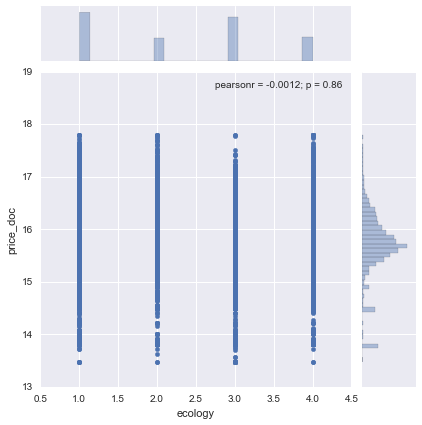

In [21]:
plot_joint(full_df, 'ecology', 'price_doc')

## 空值处理

In [22]:
full_df[feature_list] = preprocessing.Imputer(strategy='median').fit_transform(full_df[feature_list])
# full_df[feature_list] = full_df[feature_list].fillna(0)

## 预处理

In [23]:
X = full_df.loc['train'][feature_list]
y = full_df.loc['train']['price_doc']

X_pred = full_df.loc['test'][feature_list]

# 标准化
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X_pred = scaler.transform(X_pred)

X_train = X
y_train = y

## Score

In [24]:
score_name = 'RMSE'
score_func = lambda y, y_pred, **kwargs: metrics.mean_squared_error(y, y_pred, **kwargs) ** 0.5
scorer = metrics.make_scorer(score_func, greater_is_better=False)

## Lasso

In [25]:
# from sklearn.linear_model import Lasso, LassoCV

In [26]:
# # 对Lasso做网格化搜索
# search_paras = {'alpha': np.logspace(-3,0,4)}
# gs_lasso = GridSearchCV(Lasso(), search_paras, scoring=scorer).fit(X_train, y_train)
# plot_grid_search_result(gs_lasso)

In [27]:
# # lasso = gs_lasso.best_estimator_
# lasso = Lasso(**gs_lasso.best_params_).fit(X_train, y_train)

In [28]:
# coef = lasso.coef_
# coef_df = pd.Series(coef, index=feature_list)
# coef_df = coef_df.sort_values(ascending=False)
# imp_coef_df = pd.concat([coef_df.head(10), coef_df.tail(5)])
# imp_coef_df.plot(kind='barh')

## XGBoost

In [29]:
import xgboost as xgb

In [30]:
# 由于待预测数据是最近的数据，训练数据是历史数据，所以用前80%时间的数据train，后20%数据validation
split_train_rate = 0.8
split_train_num = int(split_train_rate * len(X_train))
xg_tra = xgb.DMatrix(X_train[:split_train_num], y_train[:split_train_num], feature_names=feature_list)
xg_val = xgb.DMatrix(X_train[split_train_num:], y_train[split_train_num:], feature_names=feature_list)

xg_train = xgb.DMatrix(X_train, y_train, feature_names=feature_list)
xg_pred = xgb.DMatrix(X_pred, feature_names=feature_list)

In [31]:
bst_paras = {
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'eta': 0.02,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'max_depth': 5,
#     'alpha': 0.1,
#     'lambda': 0,
}
num_boost_round = 1000

In [32]:
# xgb_cv_res = xgb.cv(bst_paras, xg_train, num_boost_round, nfold=5, early_stopping_rounds=20, verbose_eval=25)
# best_round = np.argmin(xgb_cv_res['test-rmse-mean'])
# print('best_model:', xgb_cv_res.iloc[best_round])
# # best_round = 600

In [33]:
evals = [(xg_tra, 'tra'), (xg_val, 'val')]
bst = xgb.train(bst_paras, xg_tra, num_boost_round, evals, early_stopping_rounds=20, verbose_eval=25)
print('best_round:', bst.best_iteration)
best_round = bst.best_iteration

[0]	tra-rmse:14.7927	val-rmse:14.9292
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 20 rounds.
[25]	tra-rmse:8.93768	val-rmse:9.06253
[50]	tra-rmse:5.4098	val-rmse:5.52653
[75]	tra-rmse:3.28879	val-rmse:3.40032
[100]	tra-rmse:2.02189	val-rmse:2.12198
[125]	tra-rmse:1.27727	val-rmse:1.36396
[150]	tra-rmse:0.855117	val-rmse:0.924844
[175]	tra-rmse:0.63226	val-rmse:0.682291
[200]	tra-rmse:0.525469	val-rmse:0.555425
[225]	tra-rmse:0.478034	val-rmse:0.492656
[250]	tra-rmse:0.457069	val-rmse:0.461511
[275]	tra-rmse:0.446836	val-rmse:0.446667
[300]	tra-rmse:0.44095	val-rmse:0.4385
[325]	tra-rmse:0.436747	val-rmse:0.433533
[350]	tra-rmse:0.433172	val-rmse:0.431038
[375]	tra-rmse:0.430269	val-rmse:0.428481
[400]	tra-rmse:0.42713	val-rmse:0.427336
[425]	tra-rmse:0.424238	val-rmse:0.426544
[450]	tra-rmse:0.421444	val-rmse:0.42584
[475]	tra-rmse:0.418889	val-rmse:0.42507
Stopping. Best iteration:
[473]	tra-rmse:0.4

In [34]:
evals = [(xg_train, 'train')]
bst = xgb.train(bst_paras, xg_train, best_round, evals, verbose_eval=25)
# bst = xgb.train(bst_paras, xg_train, best_round)
print('train_loss:', score_func(y_train, bst.predict(xg_train)))

[0]	train-rmse:14.8196
[25]	train-rmse:8.95363
[50]	train-rmse:5.41879
[75]	train-rmse:3.29382
[100]	train-rmse:2.02366
[125]	train-rmse:1.27603
[150]	train-rmse:0.851604
[175]	train-rmse:0.626669
[200]	train-rmse:0.518788
[225]	train-rmse:0.470923
[250]	train-rmse:0.450031
[275]	train-rmse:0.439841
[300]	train-rmse:0.434139
[325]	train-rmse:0.430021
[350]	train-rmse:0.426602
[375]	train-rmse:0.424002
[400]	train-rmse:0.421364
[425]	train-rmse:0.419018
[450]	train-rmse:0.416848
[472]	train-rmse:0.414686
train_loss: 0.414685676548


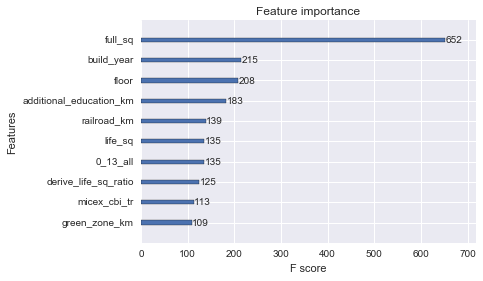

In [35]:
xgb.plot_importance(bst, max_num_features=10)

## 预测

In [36]:
# 使用的模型
# res_model = lasso
res_model = bst

# 预测
if type(res_model) == xgb.core.Booster:
    y_pred = res_model.predict(xg_pred)
else:
    y_pred = res_model.predict(X_pred)
y_pred = np.expm1(y_pred)

# 导出数据
res_df = pd.DataFrame({'id': full_df.loc['test']['id'], 'price_doc': y_pred})
res_df.to_csv('./output/result.csv', index=False)